# Aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile, orm

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
from workflow import (
    generate_structures,
    get_bulk_structure,
    calculate_qe as _calculate_qe,
    plot_energy_volume_curve,
)

In [4]:
calculate_qe = task(outputs=["energy", "volume", "structure"])(_calculate_qe)

In [5]:
wg = WorkGraph("wg-qe")

### Prepare the inputs

In [6]:
element = orm.Str("Al")
a = orm.Float(4.04)
cubic = orm.Bool(True)
relax_workdir = orm.Str("mini")
pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
kpts = orm.List([3, 3, 3])
calc_type_relax = orm.Str("vc-relax")
calc_type_scf = orm.Str("scf")
smearing = orm.Float(0.02)
strain_lst = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])

### Actual tasks to construct the EOS workflow

In [7]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    element=element,
    a=a,
    cubic=cubic,
)

In [8]:
relax_prepare_input_dict_task = wg.add_task(
    get_dict,
    structure=get_bulk_structure_task.outputs.result,
    calculation=calc_type_relax,
    kpts=kpts,
    pseudopotentials=pseudopotentials,
    smearing=smearing,
)

relax_task = wg.add_task(
    calculate_qe,
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=relax_workdir,
)

In [9]:
generate_structures_task = wg.add_task(
    generate_structures,
    structure=relax_task.outputs.structure,
    strain_lst=strain_lst,
)

In [10]:
get_volumes_task = wg.add_task(get_list)

In [11]:
get_energies_task = wg.add_task(get_list)

In [12]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = orm.Str(f"strain_{i}")
    generate_structures_task.add_output("workgraph.any", structure_key)

    scf_prepare_input_dict_task = wg.add_task(
        get_dict,
        structure=generate_structures_task.outputs[structure_key],
        calculation=calc_type_scf,
        kpts=kpts,
        pseudopotentials=pseudopotentials,
        smearing=smearing,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [13]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [15]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [16]:
!cat {workflow_json_filename}

{
  "version": "0.1.0",
  "nodes": [
    {
      "id": 0,
      "type": "function",
      "value": "workflow.get_bulk_structure"
    },
    {
      "id": 1,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 2,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 3,
      "type": "function",
      "value": "workflow.generate_structures"
    },
    {
      "id": 4,
      "type": "function",
      "value": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 5,
      "type": "function",
      "value": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 6,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 8,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
  

## Load Workflow with jobflow

In [17]:
from python_workflow_definition.jobflow import load_workflow_json

In [18]:
from jobflow.managers.local import run_locally

In [19]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [20]:
flow[0].function_kwargs["a"] = 4.05

2025-05-24 05:48:01,786 INFO Started executing jobs locally
2025-05-24 05:48:02,013 INFO Starting job - get_bulk_structure (28c24969-efdd-4239-a6bd-af123fff4298)
2025-05-24 05:48:02,017 INFO Finished job - get_bulk_structure (28c24969-efdd-4239-a6bd-af123fff4298)
2025-05-24 05:48:02,018 INFO Starting job - get_dict (ffd8792f-e232-4cd7-8a66-15d61be9e29f)
2025-05-24 05:48:02,019 INFO Finished job - get_dict (ffd8792f-e232-4cd7-8a66-15d61be9e29f)
2025-05-24 05:48:02,020 INFO Starting job - calculate_qe (69b4c8f3-8419-4df1-b569-dd1c7fefd764)


[jupyter-pythonworkflow-fl--x---d7231032:08863] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-24 05:48:54,204 INFO Finished job - calculate_qe (69b4c8f3-8419-4df1-b569-dd1c7fefd764)
2025-05-24 05:48:54,205 INFO Starting job - generate_structures (2d24374c-9473-456d-98ff-1be0c02c2bb7)
2025-05-24 05:48:54,208 INFO Finished job - generate_structures (2d24374c-9473-456d-98ff-1be0c02c2bb7)
2025-05-24 05:48:54,209 INFO Starting job - get_dict (56abaa34-f9a4-4d28-bf90-2897fe970beb)
2025-05-24 05:48:54,210 INFO Finished job - get_dict (56abaa34-f9a4-4d28-bf90-2897fe970beb)
2025-05-24 05:48:54,210 INFO Starting job - get_dict (2dd35376-658a-46ff-a277-a9b8e88ddac5)
2025-05-24 05:48:54,211 INFO Finished job - get_dict (2dd35376-658a-46ff-a277-a9b8e88ddac5)
2025-05-24 05:48:54,211 INFO Starting job - get_dict (33527acb-a9e4-4422-8198-08f80992ac9e)
2025-05-24 05:48:54,212 INFO Finished job - get_dict (33527acb-a9e4-4422-8198-08f80992ac9e)
2025-05-24 05:48:54,213 INFO Starting job - get_dict (75067890-ee04-48e4-81e3-d8bf8072b673)
2025-05-24 05:48:54,214 INFO Finished job - get_dict (

[jupyter-pythonworkflow-fl--x---d7231032:08876] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-24 05:49:04,619 INFO Finished job - calculate_qe (254a56bb-69a7-478c-a5bc-162d183e0454)
2025-05-24 05:49:04,620 INFO Starting job - calculate_qe (6f1b1b10-81d7-4f4a-95a9-c37697b4ff22)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---d7231032:08887] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-24 05:49:15,345 INFO Finished job - calculate_qe (6f1b1b10-81d7-4f4a-95a9-c37697b4ff22)
2025-05-24 05:49:15,346 INFO Starting job - calculate_qe (adfa9cb1-8d89-4943-832b-9e21782861cd)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---d7231032:08897] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-24 05:49:26,680 INFO Finished job - calculate_qe (adfa9cb1-8d89-4943-832b-9e21782861cd)
2025-05-24 05:49:26,681 INFO Starting job - calculate_qe (c8bd32cf-c431-4189-9f09-708a86fa8aa0)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---d7231032:08908] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-24 05:49:40,830 INFO Finished job - calculate_qe (c8bd32cf-c431-4189-9f09-708a86fa8aa0)
2025-05-24 05:49:40,831 INFO Starting job - calculate_qe (140c1cae-54ed-492f-8589-d9c0490142c6)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---d7231032:08919] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-24 05:49:54,690 INFO Finished job - calculate_qe (140c1cae-54ed-492f-8589-d9c0490142c6)
2025-05-24 05:49:54,691 INFO Starting job - get_list (1eade2dd-772e-4e49-8264-2ff6ee8ff6ff)
2025-05-24 05:49:54,694 INFO Finished job - get_list (1eade2dd-772e-4e49-8264-2ff6ee8ff6ff)
2025-05-24 05:49:54,694 INFO Starting job - get_list (0b1cb308-c310-4995-b18b-1441b1ff1a22)
2025-05-24 05:49:54,697 INFO Finished job - get_list (0b1cb308-c310-4995-b18b-1441b1ff1a22)
2025-05-24 05:49:54,698 INFO Starting job - plot_energy_volume_curve (2fd7c54d-8f3d-437c-a59f-8236978defdc)
2025-05-24 05:49:54,794 INFO Finished job - plot_energy_volume_curve (2fd7c54d-8f3d-437c-a59f-8236978defdc)
2025-05-24 05:49:54,795 INFO Finished executing jobs locally


{'28c24969-efdd-4239-a6bd-af123fff4298': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

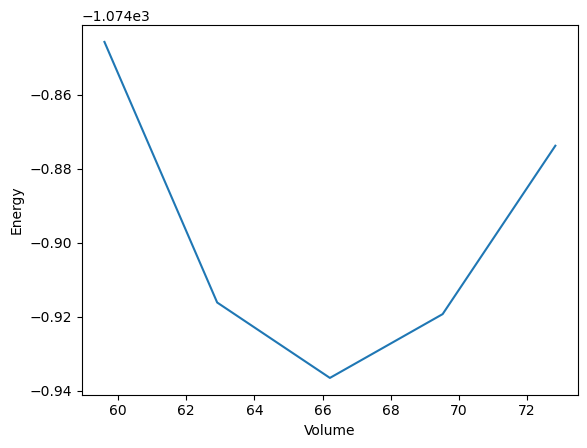

In [21]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

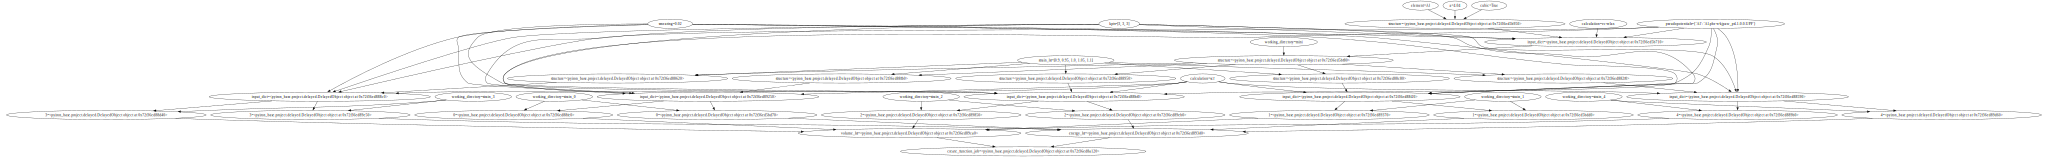

In [23]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [24]:
delayed_object_lst[0].input['a'] = 4.05

The job get_bulk_structure_2ca4aeae204ceaa28593c93054b07908 was saved and received the ID: 1
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 2
The job calculate_qe_b261e97e2e1714bf57ce6e5016ae4632 was saved and received the ID: 3


[jupyter-pythonworkflow-fl--x---d7231032:08955] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_fcb3884e78b15be7a9a6069869171c61 was saved and received the ID: 4
The job get_dict_9d50dca89ce2c8f1319206888212f261 was saved and received the ID: 5
The job calculate_qe_495edf27cca1893fd71d860b009fde57 was saved and received the ID: 6


[jupyter-pythonworkflow-fl--x---d7231032:08970] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_c6f3d017cbf308a2712facb53625f0ca was saved and received the ID: 7
The job calculate_qe_7dc568c59eb166c911415fcb78d508b6 was saved and received the ID: 8


[jupyter-pythonworkflow-fl--x---d7231032:08982] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_df08484509ac6c4b41f32ea3fb5035cf was saved and received the ID: 9
The job calculate_qe_923ca5c6b53423773a8c74e3340d3471 was saved and received the ID: 10


[jupyter-pythonworkflow-fl--x---d7231032:08993] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_04da5d650a8c957b7325cc9188f1cd07 was saved and received the ID: 11
The job calculate_qe_49ab6c2d99e5462024081421d2c1b7a7 was saved and received the ID: 12


[jupyter-pythonworkflow-fl--x---d7231032:09004] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_9d21f3f8e376847d495acc88b24aa2bd was saved and received the ID: 13
The job calculate_qe_4ca4360fd423b8cef4abf77502fef1ca was saved and received the ID: 14


[jupyter-pythonworkflow-fl--x---d7231032:09015] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_b7d643bf967628f7c04f17614baa0c5f was saved and received the ID: 15
The job get_list_1980b54721033684c33ad75357848857 was saved and received the ID: 16
The job plot_energy_volume_curve_9ba5af92db6796aafb006576962dec7c was saved and received the ID: 17


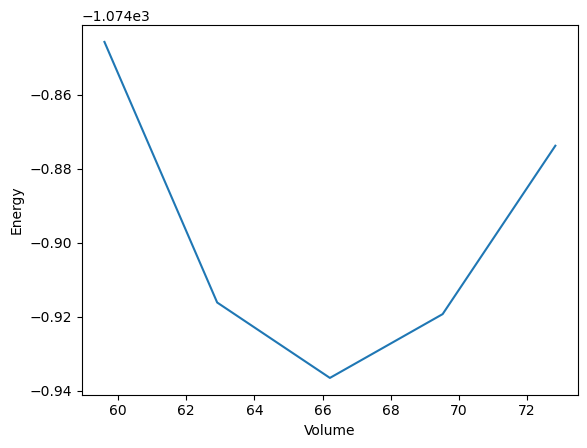

In [25]:
delayed_object_lst[-1].pull()